In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [3]:
def choose_model(best_params):
    if best_params == None:
        #return LinearRegression()
        #return RandomForestRegressor()
        return GradientBoostingRegressor()
    else:
        #return LinearRegression()
        #return RandomForestRegressor(n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"], min_samples_leaf=best_params['min_samples_leaf'], min_samples_split=best_params['min_samples_split'])
        return GradientBoostingRegressor(loss = best_params['loss'], learning_rate=best_params['learning_rate'],n_estimators=best_params["n_estimators"], 
        max_depth=best_params["max_depth"],min_samples_leaf=best_params['min_samples_leaf'], min_samples_split=best_params['min_samples_split'])

In [4]:
def choose_dataset():
    #return 'Cyclic'
    #return 'Acyclic'
    #return 'Combined'
    #return 'Cyclohexenone'
    return 'data_aug'

In [5]:
def hyperparam_tune(X, y, model):
    print(str(model))
    if str(model) == 'RandomForestRegressor()':
        hyperP = dict(n_estimators=[100, 300, 500, 800], max_depth=[None, 5, 8, 15, 25, 30],
                      min_samples_split=[2, 5, 10, 15, 100],
                      min_samples_leaf=[1, 2, 5, 10])

    elif str(model) == 'GradientBoostingRegressor()':
        hyperP = dict(loss=['squared_error'], learning_rate=[0.1, 0.2, 0.3],
                      n_estimators=[100, 300, 500, 800], max_depth=[None, 5, 8, 15, 25, 30],
                      min_samples_split=[2],
                      min_samples_leaf=[1, 2])

    gridF = GridSearchCV(model, hyperP, cv=3, verbose=1, n_jobs=-1)
    bestP = gridF.fit(X, y)
    print(bestP.best_params_)
    return bestP.best_params_

In [6]:
random_seeds = np.random.random_integers(0, high=1000, size=30)
print(random_seeds)

[607 121  75 978 245 217 693 599 879 985 948 374 912 284 427 790 536 839
 678  79  28 169 322 633 496 369 699 971 581 784]


/var/folders/6x/qf4mscbd48gf58znkh78hcy40000gn/T/ipykernel_34551/1855288125.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 1000 + 1) instead
  random_seeds = np.random.random_integers(0, high=1000, size=30)


In [7]:
descriptors = ['LVR1', 'LVR2', 'LVR3', 'LVR4', 'LVR5', 'LVR6', 'LVR7', 'VB', 'ER1', 'ER2', 'ER3', 'ER4', 'ER5', 'ER6',
               'ER7', 'SStoutR1', 'SStoutR2', 'SStoutR3', 'SStoutR4', '%top']

In [8]:
data = pd.read_csv(choose_dataset()+'.csv')

In [9]:
data = data.filter(descriptors)
#remove erroneous data
data = data.dropna(axis=0)

In [10]:
X = data.drop(['%top'], axis = 1)
X = RobustScaler().fit_transform(np.array(X))

In [11]:
y = data['%top']
print(X)
print(y)

[[ 1.          0.          0.         ...  1.11006451 -0.80260539
   0.        ]
 [ 1.          0.          0.         ...  1.         -0.80260539
   0.        ]
 [ 0.5683509   0.          0.         ...  1.         -0.80260539
   0.        ]
 ...
 [ 0.          0.          2.29749027 ...  0.          0.0662957
   0.        ]
 [ 0.          0.          1.1078541  ...  0.          0.0662957
   0.        ]
 [ 0.          0.          0.68967353 ...  1.         -0.80260539
   0.        ]]
0       6.000000
1       2.333333
2      79.000000
3      97.500000
4      91.000000
         ...    
681    96.750000
682    95.000000
683    98.000000
684    85.000000
685    99.700000
Name: %top, Length: 686, dtype: float64


In [12]:
best_params = hyperparam_tune(X, y, choose_model(best_params=None))

GradientBoostingRegressor()
Fitting 3 folds for each of 144 candidates, totalling 432 fits
{'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [13]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)
train_idx = []
test_idx = []

for i, (train, test) in enumerate(folds.split(X, np.where(y > 50, 1, 0))):
    train_idx.append(train)
    test_idx.append(test)

In [14]:
r2_cv_scores = []
rmse_cv_scores = []
mae_cv_scores = []
r2_val_scores = []
rmse_val_scores = []
mae_val_scores = []

In [15]:
for i in range(len(train_idx)):
    x_train = X[train_idx[i]]
    y_train = y[train_idx[i]]
    x_test = X[test_idx[i]]
    y_test = y[test_idx[i]]
    model = choose_model(best_params)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    r2 = r2_score(y_test, predictions)
    r2_cv_scores.append(r2)
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    rmse_cv_scores.append(rmse)
    mae = mean_absolute_error(y_test, predictions)
    mae_cv_scores.append(mae)

In [16]:
e = 24
Metrics = ['R2', 'RMSE', 'MAE']
x_pos = np.arange(len(Metrics))
CTEs = [np.mean(r2_cv_scores)*100, np.mean(rmse_cv_scores), np.mean(mae_cv_scores)]
error = [np.std(r2_cv_scores)*100, np.std(rmse_cv_scores), np.std(mae_cv_scores)]

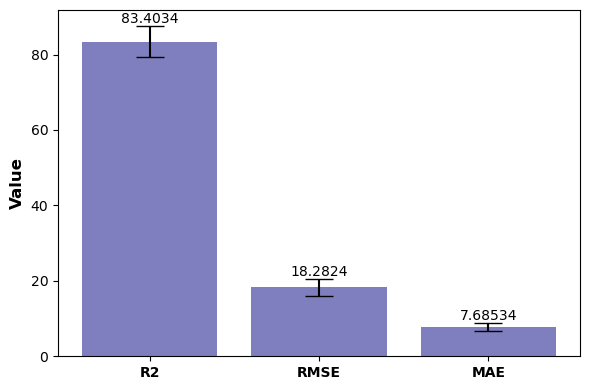

In [17]:
fig, ax = plt.subplots(figsize =(6, 4))
bars = ax.bar(x_pos, CTEs, yerr=error, align='center', color = 'navy', alpha=.5, ecolor='black', capsize=10)
ax.set_ylabel('Value', fontweight ='bold', fontsize = 12)
ax.bar_label(bars)
ax.set_xticks(x_pos)
ax.set_xticklabels(Metrics, fontweight ='bold' ,fontsize = 10)
ax.yaxis.grid(False)

plt.tight_layout()
plt.show()